In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import img_as_ubyte


# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio


# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
ORIG_SHAPE = (512, 512, 3)

In [3]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "mike/pose_0_1_meshlab.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

texture_image = mesh.textures.maps_padded()

verticies = mesh.verts_list()
faces = mesh.faces_list()
texture = mesh.textures.clone()
maps = texture.maps_padded()
faces_uvs = texture.faces_uvs_padded()
verts_uvs = texture.verts_uvs_padded()
verts_rgb = texture.verts_rgb_padded()
black_maps = torch.zeros_like(maps)
black_maps.requires_grad = True
new_texture = Textures(black_maps, faces_uvs, verts_uvs, verts_rgb)

In [4]:
new_mesh = Meshes(verticies, faces, new_texture)

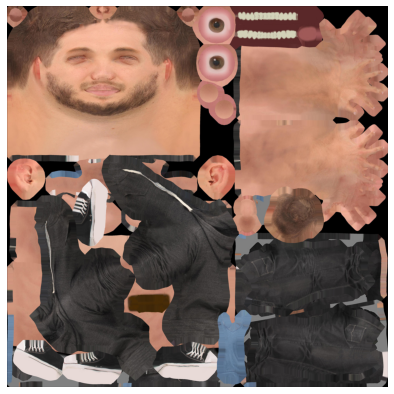

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');

In [6]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(200.0, 10, 0) 
T[0, 1] = -100
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=ORIG_SHAPE[0], 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

(-0.5, 511.5, 511.5, -0.5)

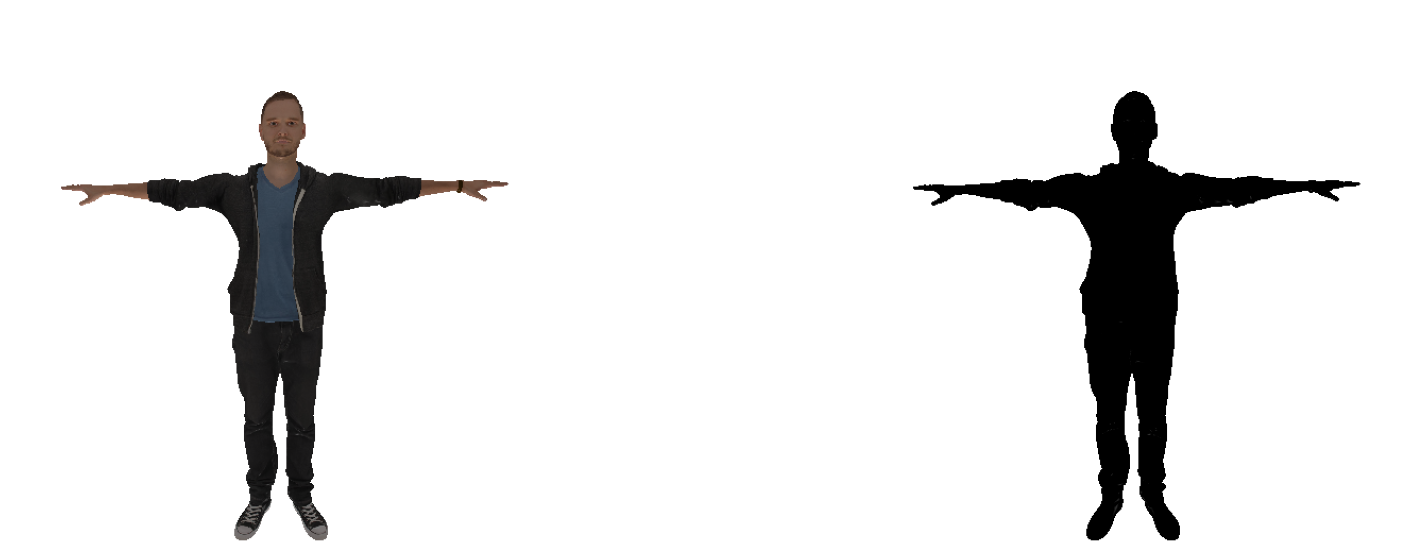

In [7]:
ref_images = renderer(mesh)
images = renderer(new_mesh)

fig = plt.figure(figsize=(28, 10))
ax = fig.add_subplot(1, 2, 1)
pcm = ax.imshow(ref_images[0, ..., :3].detach().cpu().numpy())
ax.axis('off')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(images[0, ..., :3].detach().cpu().numpy())
ax.axis('off')

In [8]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all the non zero values. 
        self.register_buffer('image_ref', image_ref)
        self.maps = nn.Parameter(
            torch.zeros_like(self.meshes.textures.maps_padded()).to(meshes.device)
        )

    def forward(self):
        # Render the image using the updated camera position. Based on the new position of the 
        # camer we calculate the rotation and translation matrices
        verticies = self.meshes.verts_list()
        faces = self.meshes.faces_list()
        
        texture = self.meshes.textures.clone()
        faces_uvs = texture.faces_uvs_padded()
        verts_uvs = texture.verts_uvs_padded()
        verts_rgb = texture.verts_rgb_padded()
        
        new_texture = Textures(self.maps, faces_uvs, verts_uvs, verts_rgb)
        
        new_mesh = Meshes(verticies, faces, new_texture)
        image = self.renderer(new_mesh)
        
        # Calculate the silhouette loss
        loss = torch.sum((image - self.image_ref) ** 2)
        return loss, image

In [9]:
# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=mesh, renderer=renderer, image_ref=ref_images).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
filename_output = "./texture_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

100%|██████████| 100/100 [00:06<00:00, 15.83it/s]


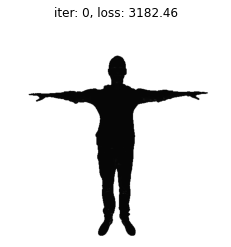

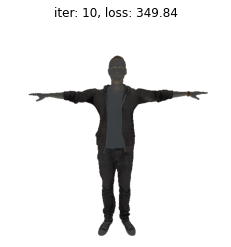

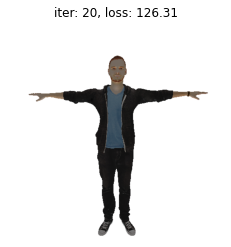

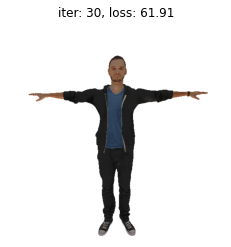

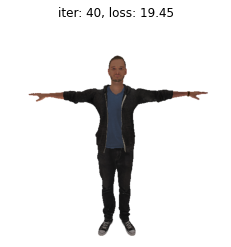

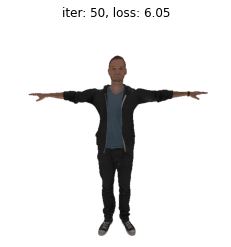

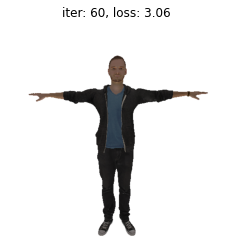

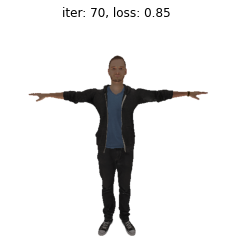

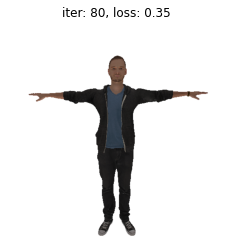

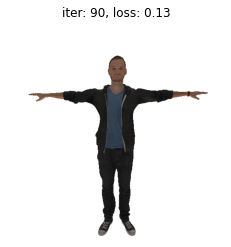

In [11]:
for i in tqdm(range(100)):
    optimizer.zero_grad()
    loss, cur_image = model()
    loss.backward()
    optimizer.step()
    
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        image = cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
    
writer.close()

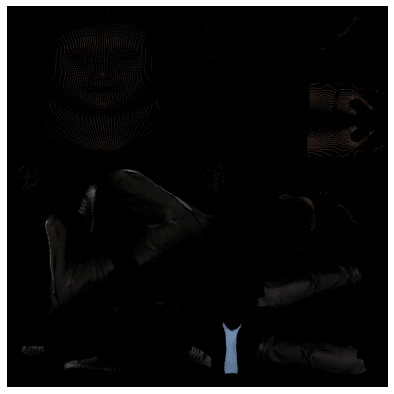

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(model.maps.squeeze().detach().cpu().numpy())
plt.grid("off");
plt.axis('off');